In [ ]:
# Install CatBoost
!pip install catboost

# Downgrade numpy to a specific version and suppress output
!pip install --upgrade --force-reinstall numpy==1.23.5 --quiet

# Restart the runtime to apply the numpy downgrade
import os
os.kill(os.getpid(), 9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 36.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 wh

In [1]:
!pip install --upgrade catboost --quiet

In [2]:
import pickle
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from catboost import CatBoostClassifier, Pool
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve


import plotly.graph_objects as go
from tqdm import tqdm

pd.set_option('display.max_columns', 1000)


In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Load data
input_train_path = "/content/drive/MyDrive/Machine_Learning_project/merged_dataset_catboost_train.parquet"
input_test_path = "/content/drive/MyDrive/Machine_Learning_project/merged_dataset_catboost_test.parquet"

train_df = pd.read_parquet(input_train_path)
test_df = pd.read_parquet(input_test_path)



# Target and features
y_train = train_df["Retained"]
X_train = train_df.drop(columns=["Retained", "ID_JOIN"])

y_test = test_df["Retained"]
X_test = test_df.drop(columns=["Retained", "ID_JOIN"])

# Automatically detect categorical features
cat_features = X_train.select_dtypes(include=["category"]).columns.tolist()

Mounted at /content/drive


In [4]:
# Detect all object columns and convert them to categorical
object_cols = X_train.select_dtypes(include="object").columns

for col in object_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# Update cat_features list
cat_features = list(set(cat_features + object_cols.tolist()))

In [5]:
# Ensure all categorical features are actually categorical dtype
for col in cat_features:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

In [6]:
print(X_train[cat_features].dtypes)
#print(X_train[cat_features].head())

Special_Pay           category
GroupGradeType        category
DepartureMonth        category
GroupGradeTypeHigh    category
School_Type           category
GroupGradeTypeLow     category
Region                category
SchoolGradeType       category
Group_State           category
Travel_Type           category
SPR_Product_Type      category
Program_Code          category
MDR_Low_Grade         category
MajorProgramCode      category
dtype: object


In [7]:
# Fix all category columns to replace NaNs with "Missing"
for col in X_train.select_dtypes(include="category").columns:
    if X_train[col].isnull().any():
        X_train[col] = X_train[col].cat.add_categories("Missing").fillna("Missing")
    if X_test[col].isnull().any():
        X_test[col] = X_test[col].cat.add_categories("Missing").fillna("Missing")

In [9]:
%%time

catboost_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=0,
    random_state=42
)

# Hyperparameter space
param_dist = {
    'depth': [6, 8],
    'learning_rate': [0.04, 0.06, 0.1],
    'iterations': [120, 200, 300],
    'l2_leaf_reg': [0.8, 1, 2, 3],
    'bagging_temperature': [0.2, 0.5, 0.8],
    'border_count': [32, 64, 128]
}

# CV and search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit with Pool for CatBoost
random_search.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test)
)

best_model = random_search.best_estimator_

# Predict
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

# Evaluation
auc_train = roc_auc_score(y_train, y_pred_proba_train)
auc_test = roc_auc_score(y_test, y_pred_proba_test)
logloss_test = log_loss(y_test, y_pred_proba_test)

print("Best Params:", random_search.best_params_)
print("Train AUC:", round(auc_train, 4))
print("Test AUC:", round(auc_test, 4))
print("Test LogLoss:", round(logloss_test, 4))




Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'learning_rate': 0.06, 'l2_leaf_reg': 0.8, 'iterations': 300, 'depth': 8, 'border_count': 32, 'bagging_temperature': 0.5}
Train AUC: 1.0
Test AUC: 0.8949
Test LogLoss: 0.394
CPU times: user 21.7 s, sys: 2.98 s, total: 24.7 s
Wall time: 10min 18s


    remaining_features                  dropped_feature  train_auc  test_auc  \
0                   65                     Program_Code   0.999513  0.878871   
1                   64                    MDR_Low_Grade   0.999930  0.871454   
2                   63                 SPR_Product_Type   0.999615  0.863034   
3                   62                   DepartureMonth   0.999763  0.868586   
4                   61                  SchoolGradeType   0.999976  0.875213   
5                   60                 MajorProgramCode   0.999954  0.867543   
6                   59              Parent_Meeting_Flag   0.999909  0.872256   
7                   58                      Travel_Type   0.999922  0.866640   
8                   57                   GroupGradeType   0.999935  0.872100   
9                   56                      School_Type   0.999954  0.868766   
10                  55      NumberOfMeetingswithParents   0.999981  0.874378   
11                  54           Deposit

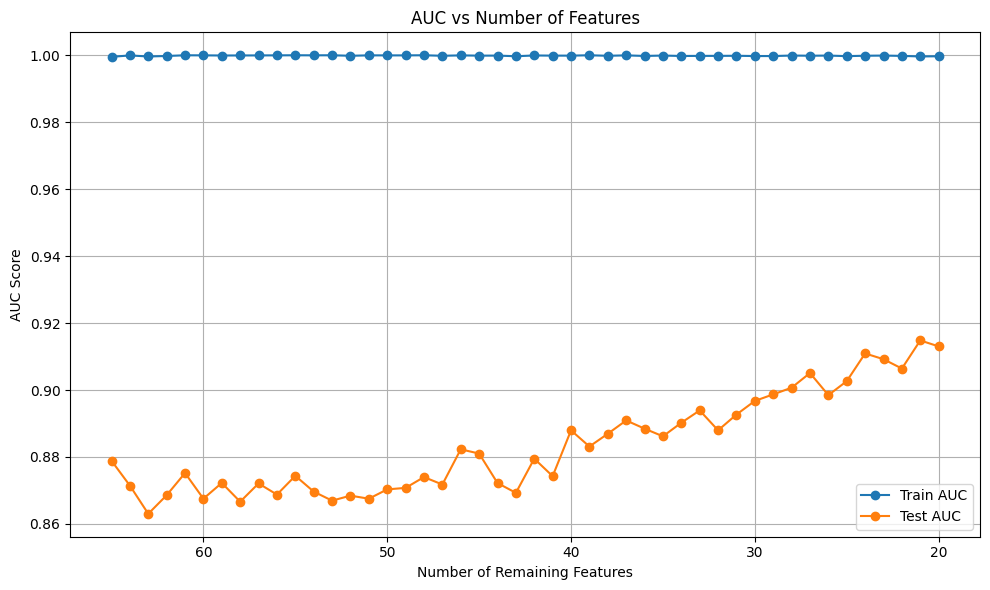

CPU times: user 9min 51s, sys: 13.1 s, total: 10min 4s
Wall time: 6min 13s


In [ ]:
%%time

import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, log_loss

# Initialize full feature set
current_features = X_train.columns.tolist()
cat_features_subset = [f for f in current_features if f in cat_features]

# Performance tracking
performance_log = []

while len(current_features) > 20:
    # Build pools
    train_pool = Pool(X_train[current_features], y_train, cat_features=[f for f in current_features if f in cat_features])
    test_pool = Pool(X_test[current_features], y_test, cat_features=[f for f in current_features if f in cat_features])

    # Train model
    model = CatBoostClassifier(
        iterations=150,
        depth=8,
        learning_rate=0.08,
        l2_leaf_reg=1,
        border_count=32,
        bagging_temperature=0.5,
        loss_function='Logloss',
        eval_metric='AUC',
        bootstrap_type='Bayesian',
        verbose=0,
        random_state=42
    )
    model.fit(train_pool)

    # Evaluate
    y_pred_train = model.predict_proba(X_train[current_features])[:, 1]
    y_pred_test = model.predict_proba(X_test[current_features])[:, 1]

    auc_train = roc_auc_score(y_train, y_pred_train)
    auc_test = roc_auc_score(y_test, y_pred_test)
    logloss_test = log_loss(y_test, y_pred_test)

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train[current_features])

    # Get least important feature
    shap_df = pd.DataFrame({
        'feature': current_features,
        'importance': np.abs(shap_values).mean(axis=0)
    }).sort_values(by='importance', ascending=True)

    # Drop the least important feature
    feature_to_drop = shap_df.iloc[0]['feature']
    current_features.remove(feature_to_drop)

    # Log performance
    performance_log.append({
        'remaining_features': len(current_features),
        'dropped_feature': feature_to_drop,
        'train_auc': auc_train,
        'test_auc': auc_test,
        'test_logloss': logloss_test
    })

# Convert log to DataFrame
performance_df = pd.DataFrame(performance_log)
print(performance_df)

# Final top 20 features
top_20_features = current_features
print("Final 20 Features:", top_20_features)

# ========================
# 📈 Plot AUC vs. features
# ========================
plt.figure(figsize=(10, 6))
plt.plot(performance_df['remaining_features'], performance_df['train_auc'], label='Train AUC', marker='o')
plt.plot(performance_df['remaining_features'], performance_df['test_auc'], label='Test AUC', marker='o')
plt.gca().invert_xaxis()  # Optional: show feature reduction left to right
plt.title('AUC vs Number of Features')
plt.xlabel('Number of Remaining Features')
plt.ylabel('AUC Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
top_20_features = [
 'Group_State', 'Cancelled_Pax', 'Total_Pax', 'GroupGradeTypeLow', 'FPP_to_School_enrollment',
 'Poverty_Code', 'MDR_High_Grade', 'Income_Level', 'DifferenceTraveltoFirstMeeting',
 'DifferenceTraveltoLastMeeting', 'SchoolSizeIndicator', 'FRP_Active',
 'FRP_Take_up_percent_', 'EZ_Pay_Take_Up_Rate', 'SPR_Group_Revenue', 'grade_diff',
 'LastMeeting_month_cos', 'Departure_Date_month_cos',
 'Initial_System_Date_month_sin', 'Initial_System_Date_month_cos'
]


In [ ]:
%%time
# Select reduced feature set
X_train_top20 = X_train[top_20_features]
X_test_top20 = X_test[top_20_features]

# Filter cat_features
cat_features_top20 = [f for f in top_20_features if f in cat_features]

# Define model
catboost_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=0,
    random_state=42
)

# Parameter grid
param_dist = {
    'iterations': [200, 300],                   # Slightly fewer iterations to reduce complexity
    'learning_rate': [0.01, 0.03, 0.05],         # Lower LR = smoother learning
    'depth': [4, 5, 6],                          # Shallow trees generalize better
    'l2_leaf_reg': [10, 20, 30],                 # Stronger L2 regularization
    'bagging_temperature': [1.0, 1.5, 2.0],      # Increase randomness for generalization
    'rsm': [0.6, 0.8],                           # Feature subsampling (randomness + regularization)
    'border_count': [32, 64],                    # Less granularity in splits = less overfitting
    'bootstrap_type': ['Bayesian'],              # Keep Bayesian (good uncertainty handling)
    'grow_policy': ['SymmetricTree']             # Avoid overly deep trees with Oblivious splits
}
# Cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Random search with early stopping passed in fit_params
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit with early stopping
random_search.fit(
    X_train_top20, y_train,
    cat_features=cat_features_top20,
    eval_set=(X_test_top20, y_test),
    early_stopping_rounds=20
)

# Evaluation
best_model = random_search.best_estimator_
y_pred_train = best_model.predict_proba(X_train_top20)[:, 1]
y_pred_test = best_model.predict_proba(X_test_top20)[:, 1]

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)
logloss_test = log_loss(y_test, y_pred_test)

# Output
print("Best Parameters:", random_search.best_params_)
print("Train AUC:", round(auc_train, 4))
print("Test AUC:", round(auc_test, 4))
print("Test LogLoss:", round(logloss_test, 4))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best Parameters: {'rsm': 0.8, 'learning_rate': 0.05, 'l2_leaf_reg': 10, 'iterations': 300, 'grow_policy': 'SymmetricTree', 'depth': 6, 'border_count': 64, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.0}
Train AUC: 0.9644
Test AUC: 0.8689
Test LogLoss: 0.4365
CPU times: user 5.33 s, sys: 759 ms, total: 6.09 s
Wall time: 4min 29s


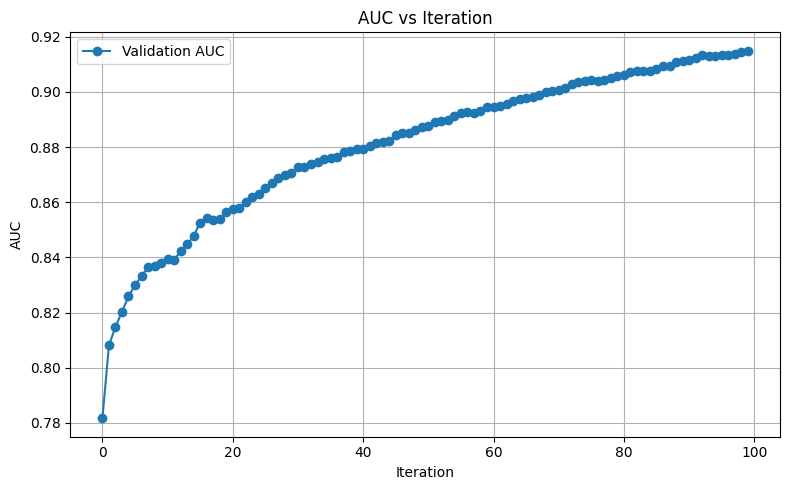

In [ ]:
# Get evaluation results
evals_result = model.get_evals_result()

# Plot AUC vs iteration

plt.figure(figsize=(8, 5))
plt.plot(evals_result['validation']['AUC'], label='Validation AUC', marker='o')
plt.xlabel("Iteration")
plt.ylabel("AUC")
plt.title("AUC vs Iteration")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## FEATURE INTERPRETATION

                           feature  importance
15                      grade_diff    0.885960
2                        Total_Pax    0.392970
10             SchoolSizeIndicator    0.188124
11                      FRP_Active    0.172000
0                      Group_State    0.161896
18   Initial_System_Date_month_sin    0.160855
3                GroupGradeTypeLow    0.136591
5                     Poverty_Code    0.116005
12            FRP_Take_up_percent_    0.105360
4         FPP_to_School_enrollment    0.100439
6                   MDR_High_Grade    0.096783
9    DifferenceTraveltoLastMeeting    0.080379
16           LastMeeting_month_cos    0.080003
14               SPR_Group_Revenue    0.079555
1                    Cancelled_Pax    0.079434
8   DifferenceTraveltoFirstMeeting    0.078510
7                     Income_Level    0.069089
19   Initial_System_Date_month_cos    0.065345
13             EZ_Pay_Take_Up_Rate    0.064359
17        Departure_Date_month_cos    0.033950


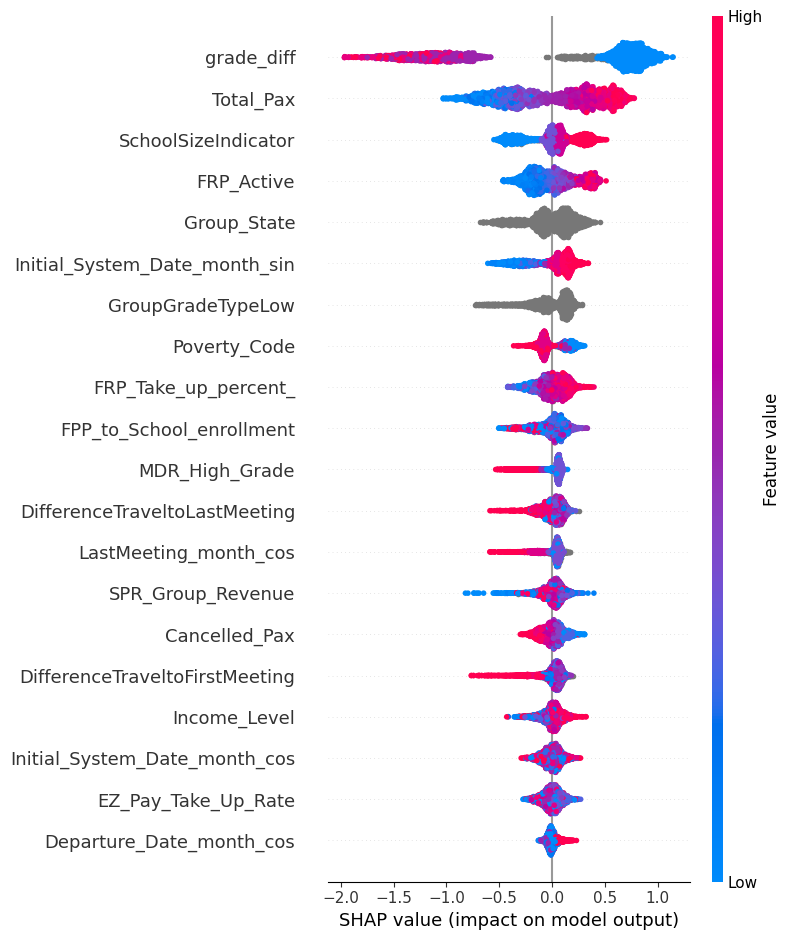

In [ ]:
# Compute SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train[top_20_features])

# Create DataFrame of mean absolute SHAP values
shap_df = pd.DataFrame({
    'feature': top_20_features,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

# Display top SHAP values
print(shap_df)

# Plot summary
shap.summary_plot(shap_values, X_train[top_20_features])

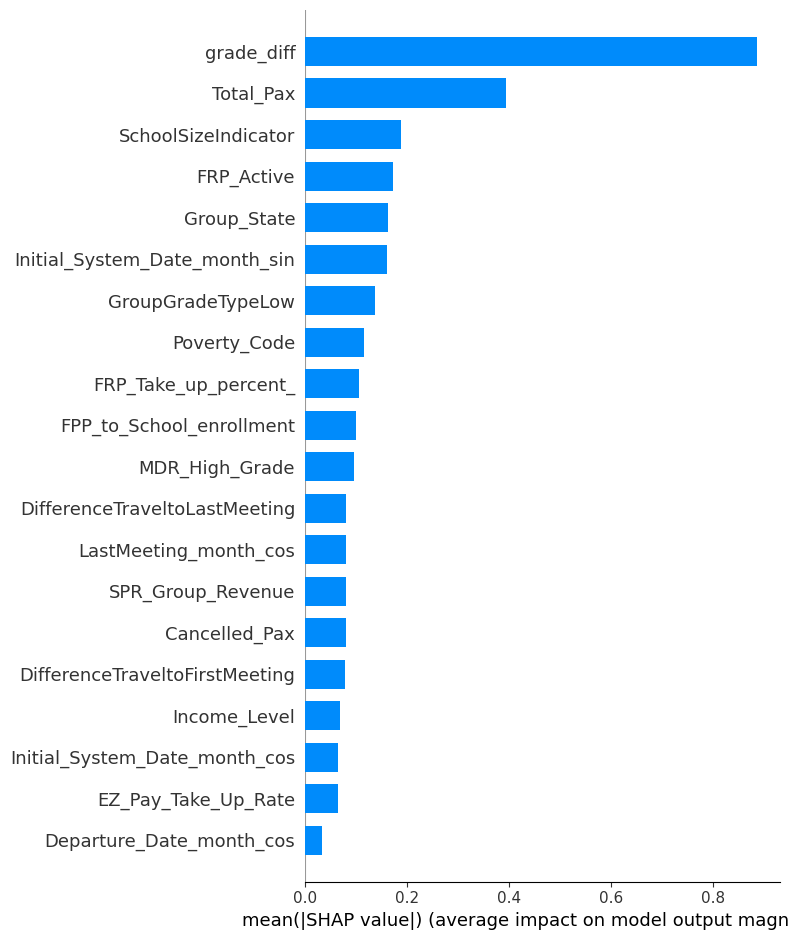

In [ ]:
shap.summary_plot(shap_values, X_test[top_20_features], plot_type="bar")

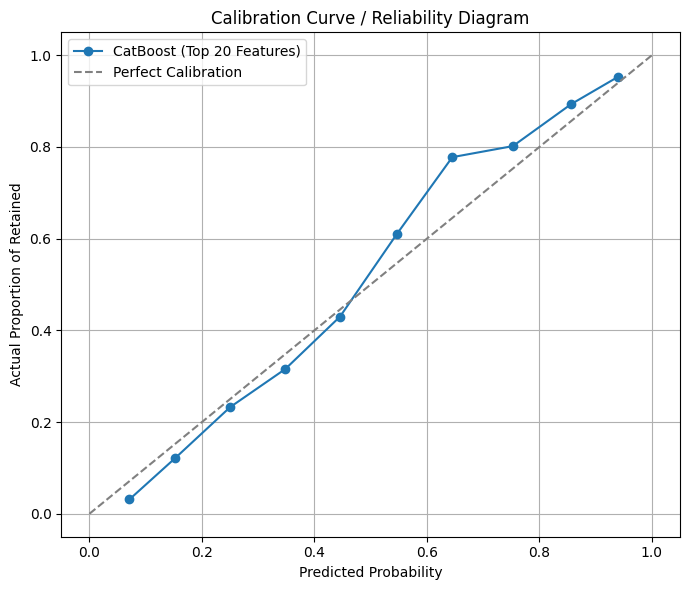

In [ ]:
# PredictED probabilities for the positive class
y_pred_proba = best_model.predict_proba(X_test[top_20_features])[:, 1]

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='uniform')

# Plot
plt.figure(figsize=(7, 6))
plt.plot(prob_pred, prob_true, marker='o', label='CatBoost (Top 20 Features)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Proportion of Retained')
plt.title('Calibration Curve / Reliability Diagram')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# === 1. Save final CatBoost model ===
final_model_path = "/content/drive/MyDrive/Machine_Learning_project/final_catboost_model.pkl"

with open(final_model_path, "wb") as f:
    pickle.dump(best_model, f)

print("✅ Model saved to:", final_model_path)

✅ Model saved to: /content/drive/MyDrive/Machine_Learning_project/final_catboost_model.pkl


In [ ]:
# Set output paths
train_save_path = "/content/drive/MyDrive/Machine_Learning_project/final_train_top20.parquet"
test_save_path = "/content/drive/MyDrive/Machine_Learning_project/final_test_top20.parquet"

# Save the filtered datasets
X_train[top_20_features].assign(Retained=y_train).to_parquet(train_save_path, index=False)
X_test[top_20_features].assign(Retained=y_test).to_parquet(test_save_path, index=False)

print("✅ Datasets saved with top 20 features:")
print("Train →", train_save_path)
print("Test  →", test_save_path)

✅ Datasets saved with top 20 features:
Train → /content/drive/MyDrive/Machine_Learning_project/final_train_top20.parquet
Test  → /content/drive/MyDrive/Machine_Learning_project/final_test_top20.parquet


In [ ]:
# Define hyperparameter ranges
depths = [4, 6, 8, 10, 15]
iterations = [50, 70, 100, 200, 400, 700, 900]
learning_rate = 0.05
l2_leaf_reg = 3
border_count = 64
bagging_temperature = 0.5

# Prepare data collectors
results = []

# Grid search over depth and iterations
for d in tqdm(depths, desc="Depth loop"):
    for i in iterations:
        model = CatBoostClassifier(
            depth=d,
            iterations=i,
            learning_rate=learning_rate,
            l2_leaf_reg=l2_leaf_reg,
            border_count=border_count,
            bagging_temperature=bagging_temperature,
            loss_function='Logloss',
            eval_metric='AUC',
            verbose=0,
            random_state=42
        )
        model.fit(X_train, y_train, cat_features=cat_features)
        train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
        test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

        results.append((d, i, train_auc, test_auc))

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=["depth", "iterations", "train_auc", "test_auc"])

# Pivot to matrices
train_auc_matrix = results_df.pivot(index='depth', columns='iterations', values='train_auc').values
test_auc_matrix = results_df.pivot(index='depth', columns='iterations', values='test_auc').values

# Create meshgrid
X, Y = np.meshgrid(iterations, depths)

# 3D plot
fig = go.Figure()

fig.add_trace(go.Surface(z=train_auc_matrix, x=X, y=Y, colorscale='Blues', name='Train AUC'))
fig.add_trace(go.Surface(z=test_auc_matrix, x=X, y=Y, colorscale='Reds', name='Test AUC', opacity=0.9))

fig.update_layout(
    title="Train vs Test AUC - CatBoost",
    scene=dict(
        xaxis_title='Iterations',
        yaxis_title='Depth',
        zaxis_title='AUC'
    ),
    width=800,
    height=600
)

fig.show()

Depth loop:  80%|████████  | 4/5 [05:34<01:44, 104.01s/it]

## For the kaggle competition

In [15]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import pickle

# === Prepare Data ===
X_train_top20 = X_train[top_20_features]
X_test_top20 = X_test[top_20_features]

# Detect categorical features
cat_features = X_train_top20.select_dtypes(include=['category', 'object']).columns.tolist()

# === Define Best Hyperparameters ===
best_params = {
    'learning_rate': 0.08,
    'l2_leaf_reg': 2,
    'iterations': 100,
    'depth': 9,
    'border_count': 32,
    'bagging_temperature': 0.8,
    'verbose': 0,
    'random_seed': 42
}

# === Train Model ===
overfit_model = CatBoostClassifier(**best_params)
overfit_model.fit(X_train_top20, y_train, cat_features=cat_features)

# === Predict Probabilities ===
y_train_pred = overfit_model.predict_proba(X_train_top20)[:, 1]
y_test_pred = overfit_model.predict_proba(X_test_top20)[:, 1]

# === Calculate AUC ===
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print(f"✅ Train AUC: {train_auc:.4f}")
print(f"✅ Test AUC: {test_auc:.4f}")

# === Save Model ===
overfit_model_path = "/content/drive/MyDrive/Machine_Learning_project/final_catboost_model_overfit.pkl"

with open(overfit_model_path, "wb") as f:
    pickle.dump(overfit_model, f)

print("✅ Model saved to:", overfit_model_path)

✅ Train AUC: 0.9982
✅ Test AUC: 0.9150
✅ Model saved to: /content/drive/MyDrive/Machine_Learning_project/final_catboost_model_overfit.pkl
